In [74]:
import os
from pathlib import Path
import datetime
import json

import ee
import geemap
import numpy as np
import geopandas as gpd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [75]:
## Make sure you're using an environment with geemap
import sys
print('environment:',  sys.executable.split('/')[-3])

environment: geemap


## 1. Validation points

In [76]:
path = Path('../data/features/nigeria/nigeria_stratified_labelled_v1_splits_resampled.shp')
gdf = gpd.read_file(path)
gdf

,identifier,date,lat,lon,label,filename,set,new_set,geometry
0,22,2019-04-03_2020-03-28,12.720998,11.665657,0,22_2019-04-03_2020-03-28.pkl,training,training,POINT (11.66566 12.72100)
1,695,2019-04-03_2020-03-28,8.605277,4.593760,0,695_2019-04-03_2020-03-28.pkl,training,training,POINT (4.59376 8.60528)
2,372,2019-04-03_2020-03-28,5.029802,6.423448,0,372_2019-04-03_2020-03-28.pkl,training,training,POINT (6.42345 5.02980)
3,637,2019-04-03_2020-03-28,11.347294,13.610150,0,637_2019-04-03_2020-03-28.pkl,training,training,POINT (13.61015 11.34729)
4,1803,2019-04-03_2020-03-28,12.330321,11.564147,1,1803_2019-04-03_2020-03-28.pkl,training,training,POINT (11.56415 12.33032)
...,...,...,...,...,...,...,...,...,...
1822,1558,2019-04-03_2020-03-28,10.400290,12.268247,0,1558_2019-04-03_2020-03-28.pkl,validation,testing,POINT (12.26825 10.40029)
1823,992,2019-04-03_2020-03-28,5.009051,8.392915,0,992_2019-04-03_2020-03-28.pkl,training,testing,POINT (8.39291 5.00905)
1824,1515,2019-04-03_2020-03-28,9.070604,11.897153,0,1515_2019-04-03_2020-03-28.pkl,training,testing,POINT (11.89715 9.07060)
1825,600,2019-04-03_2020-03-28,6.494056,7.806045,1,600_2019-04-03_2020-03-28.pkl,training,testing,POINT (7.80605 6.49406)


In [77]:
eval_set = 'testing'
val_gdf = gdf[gdf['new_set'] == eval_set]
val_gdf

,identifier,date,lat,lon,label,filename,set,new_set,geometry
1371,199,2019-04-03_2020-03-28,7.506996,5.723391,0,199_2019-04-03_2020-03-28.pkl,training,testing,POINT (5.72339 7.50700)
1372,1462,2019-04-03_2020-03-28,7.596289,8.447353,0,1462_2019-04-03_2020-03-28.pkl,training,testing,POINT (8.44735 7.59629)
1373,1677,2019-04-03_2020-03-28,9.313239,3.724280,0,1677_2019-04-03_2020-03-28.pkl,training,testing,POINT (3.72428 9.31324)
1374,749,2019-04-03_2020-03-28,8.707595,7.526669,0,749_2019-04-03_2020-03-28.pkl,validation,testing,POINT (7.52667 8.70759)
1375,757,2019-04-03_2020-03-28,12.584903,6.177490,0,757_2019-04-03_2020-03-28.pkl,training,testing,POINT (6.17749 12.58490)
...,...,...,...,...,...,...,...,...,...
1822,1558,2019-04-03_2020-03-28,10.400290,12.268247,0,1558_2019-04-03_2020-03-28.pkl,validation,testing,POINT (12.26825 10.40029)
1823,992,2019-04-03_2020-03-28,5.009051,8.392915,0,992_2019-04-03_2020-03-28.pkl,training,testing,POINT (8.39291 5.00905)
1824,1515,2019-04-03_2020-03-28,9.070604,11.897153,0,1515_2019-04-03_2020-03-28.pkl,training,testing,POINT (11.89715 9.07060)
1825,600,2019-04-03_2020-03-28,6.494056,7.806045,1,600_2019-04-03_2020-03-28.pkl,training,testing,POINT (7.80605 6.49406)


In [78]:
val_gdf.label.value_counts()

0    273
1    183
Name: label, dtype: int64

<AxesSubplot: >

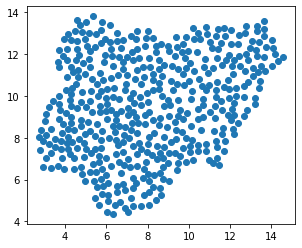

In [79]:
val_gdf.plot()

Transform points to feature collection

In [80]:
#ee.Authenticate()

In [81]:
ee.Initialize()

In [82]:
val_points = geemap.geopandas_to_ee(val_gdf)
val_points

## 2. Landcover products


- ESA WorldCover
- ESRI 2020
- Dynamic world

In [83]:
# Definitions and helper functions

results = {}
nigeria_boundaries = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Nigeria'))

def calculate_confusion(val_df, column_name, target_value):
    tp = len(val_df[(val_df[column_name] == target_value) & (val_df['label'] == 1.0)])
    fn = len(val_df[(val_df[column_name] != target_value) & (val_df['label'] == 1.0)])
    fp = len(val_df[(val_df[column_name] == target_value) & (val_df['label'] == 0.0)])
    tn = len(val_df[(val_df[column_name] != target_value) & (val_df['label'] == 0.0)])
    return (tp, fn, fp, tn)


def calculate_metrics(tp, fn, fp, tn):
    total_acc = (tp + tn) / (tp + fn + fp + tn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1_score = 2 * (precision * recall) / (precision + recall)
    selectivity = tn / (fp + tn)
    return {'total_acc': total_acc, 'recall': recall, 'precision': precision, 'f1_score': f1_score, 'selectivity': selectivity, 'confusion': {'tp': tp, 'fn': fn, 'fp': fp, 'tn': tn}}

def plot_confusion_matrix(tp: int, fn: int, fp: int, tn: int, title: str, save_fig: bool=False) -> ConfusionMatrixDisplay: 
    print(tp, fn, fp, tn)
    cm = np.array([[tn, fp], [fn, tp]])
    cm_display = ConfusionMatrixDisplay(cm)

    fig, ax = plt.subplots(1, 1)
    cm_display.plot(ax=ax)
    labels = ['non-cropland', 'cropland']
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels, rotation=90)
    fig.suptitle(f'Confusion matrix {title}')

    if save_fig:
        fig.savefig(f'../figures/confusion_matrix_nigeria_{eval_set}_{title.replace(" ", "_")}', facecolor='white')

    return cm_display


### 2.1 ESA WorldCover

Access [ESA Global Land Cover](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v100) landcover product via the GEE catalog.

In [84]:
esa = ee.ImageCollection("ESA/WorldCover/v100") #.first()
esa

Name,Description
Map,Landcover class


Image collection

In [85]:
print(esa.getInfo())

{'type': 'ImageCollection', 'bands': [], 'id': 'ESA/WorldCover/v100', 'version': 1668606593514996, 'properties': {'date_range': [1577836800000, 1609459200000], 'period': 0, 'type_name': 'ImageCollection', 'max_mirrored_version': 1634633454597615, 'keywords': ['esa', 'landcover', 'landuse', 'sentinel1-derived', 'sentinel2-derived'], 'description': '<p>The European Space Agency (ESA) WorldCover 10 m 2020 product provides a\nglobal land cover map for 2020 at 10 m resolution based on Sentinel-1 and\nSentinel-2 data. The WorldCover product comes with 11 land cover classes and\nhas been generated in the framework of the ESA WorldCover project, part of the\n5th Earth Observation Envelope Programme (EOEP-5) of the European Space Agency.</p><p>See also:</p><ul><li><a href="https://esa-worldcover.org">ESA WorldCover website</a></li><li><a href="https://esa-worldcover.org/en/data-access">User Manual and Validation Report</a></li></ul><p><b>Provider: <a href="https://esa-worldcover.org/en">ESA/VIT

In [86]:
print('Image collection\'s length:', esa.size().getInfo())

Image collection's length: 1


In [87]:
start, end = esa.getInfo()['properties']['date_range']
utc_to_datetime = lambda x: datetime.datetime.utcfromtimestamp(x/1000.0)
utc_to_datetime(start), utc_to_datetime(end)

(datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2021, 1, 1, 0, 0))

Get image and info

In [88]:
esa_image = esa.first()
esa_image_info = esa_image.getInfo()
print(esa_image_info)

{'type': 'Image', 'bands': [{'id': 'Map', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [4320000, 1728000], 'crs': 'EPSG:4326', 'crs_transform': [8.333333333333333e-05, 0, -180, 0, -8.333333333333333e-05, 84]}], 'version': 1668606593514996, 'id': 'ESA/WorldCover/v100/2020', 'properties': {'system:time_start': 1577836800000, 'Map_class_names': ['Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 'Bare / sparse vegetation', 'Snow and ice', 'Permanent water bodies', 'Herbaceous wetland', 'Mangroves', 'Moss and lichen'], 'system:footprint': {'type': 'LinearRing', 'coordinates': [[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]}, 'system:time_end': 1609459200000, 'Map_class_palette': ['006400', 'ffbb22', 'ffff4c', 'f096ff', 'fa0000', 'b4b4b4', 'f0f0f0', '0064c8', '0096a0', '00cf75', 'fae6a0'], 'Map_class_values': [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100], 'system:asset_size': 109355097577, 'system:index': '2020'}}


In [89]:
utc_to_datetime(esa_image_info['properties']['system:time_start']), utc_to_datetime(esa_image_info['properties']['system:time_end']) 

(datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2021, 1, 1, 0, 0))

Get cropland class pixel value

In [90]:
class_name = 'Cropland'
esa_cropland_index = esa_image_info['properties']['Map_class_names'].index(class_name)
esa_cropland_value = esa_image_info['properties']['Map_class_values'][esa_cropland_index]
esa_cropland_value

40

Evaluate on validation points

In [91]:
results_val_points = esa_image.reduceRegions(**{'collection': val_points, 'reducer': ee.Reducer.median()})
results_val_gdf = geemap.ee_to_geopandas(results_val_points)
results_val_gdf.rename(columns={'median': 'ESA_pixel_value'}, inplace=True)
results_val_gdf

,geometry,date,filename,identifier,label,lat,lon,ESA_pixel_value,new_set,set
0,POINT (5.72339 7.50700),2019-04-03_2020-03-28,199_2019-04-03_2020-03-28.pkl,199,0,7.506996,5.723391,10,testing,training
1,POINT (8.44735 7.59629),2019-04-03_2020-03-28,1462_2019-04-03_2020-03-28.pkl,1462,0,7.596289,8.447353,20,testing,training
2,POINT (3.72428 9.31324),2019-04-03_2020-03-28,1677_2019-04-03_2020-03-28.pkl,1677,0,9.313239,3.724280,20,testing,training
3,POINT (7.52667 8.70759),2019-04-03_2020-03-28,749_2019-04-03_2020-03-28.pkl,749,0,8.707595,7.526669,20,testing,validation
4,POINT (6.17749 12.58490),2019-04-03_2020-03-28,757_2019-04-03_2020-03-28.pkl,757,0,12.584903,6.177490,40,testing,training
...,...,...,...,...,...,...,...,...,...,...
451,POINT (12.26825 10.40029),2019-04-03_2020-03-28,1558_2019-04-03_2020-03-28.pkl,1558,0,10.400290,12.268247,40,testing,validation
452,POINT (8.39291 5.00905),2019-04-03_2020-03-28,992_2019-04-03_2020-03-28.pkl,992,0,5.009051,8.392915,10,testing,training
453,POINT (11.89715 9.07060),2019-04-03_2020-03-28,1515_2019-04-03_2020-03-28.pkl,1515,0,9.070604,11.897153,20,testing,training
454,POINT (7.80605 6.49406),2019-04-03_2020-03-28,600_2019-04-03_2020-03-28.pkl,600,1,6.494056,7.806045,10,testing,training


In [92]:
results_val_gdf['ESA_pixel_value'].value_counts()

40    151
10     91
30     90
20     89
60     16
80      7
95      6
50      3
90      3
Name: ESA_pixel_value, dtype: int64

Confusion matrix

In [93]:
tp, fn, fp, tn = calculate_confusion(results_val_gdf, 'ESA_pixel_value', esa_cropland_value)

In [94]:
len(results_val_gdf) == (tp + fn + fp + tn)

True

In [95]:
results['ESA'] = calculate_metrics(tp=tp, fn=fn, fp=fp, tn=tn)
results

{'ESA': {'total_acc': 0.868421052631579,
  'recall': 0.7486338797814208,
  'precision': 0.9072847682119205,
  'f1_score': 0.8203592814371257,
  'selectivity': 0.9487179487179487,
  'confusion': {'tp': 137, 'fn': 46, 'fp': 14, 'tn': 259}}}

137 46 14 259


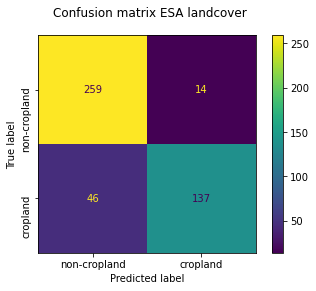

In [96]:
plot_confusion_matrix(**results['ESA']['confusion'], title='ESA landcover', save_fig=True)

**Visualization**

In [97]:
Map = geemap.Map()

Map.setCenter(9.136, 7.433, 6)

esa_vis = {'bands': ['Map']}

Map.addLayer(esa_image.clip(nigeria_boundaries), esa_vis, "ESA Land Cover")
Map.add_legend(title="ESA Land Cover", builtin_legend='ESA_WorldCover')

Map.addLayer(val_points, {}, "Validation points")

Map

Map(center=[7.433, 9.136], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

### 2.2 ESRI 2020

Access [ESRI 2020 Global Land Cover](https://samapriya.github.io/awesome-gee-community-datasets/projects/esrilc2020/) landcover product via a community added public asset in GEE catalog.

In [98]:
esri = ee.ImageCollection("projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m")
esri_info = esri.getInfo()
esri_info

{'type': 'ImageCollection',
 'bands': [],
 'version': 1624668441802946,
 'id': 'projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m',
 'features': [{'type': 'Image',
   'bands': [{'id': 'b1',
     'data_type': {'type': 'PixelType',
      'precision': 'int',
      'min': 0,
      'max': 255},
     'dimensions': [27922, 32025],
     'crs': 'EPSG:32701',
     'crs_transform': [10,
      0,
      365215.04551425716,
      0,
      -10,
      1381432.0991431829]}],
   'version': 1624644462274581,
   'id': 'projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m/01C_20200101-20210101',
   'properties': {'num_bands': 1,
    'id_no': '01C_20200101-20210101',
    'ysize': 32025,
    'system:footprint': {'type': 'LinearRing',
     'coordinates': [[176.2162454956937, -79.72499763854299],
      [175.97416745526368, -80.08104203780834],
      [175.71390916290045, -80.43697590455974],
      [-169.1984008146848, -80.42578331626476],
      [-169.4766544104135, -80.07025809952935],
      

In [99]:
print('Image collection\'s length:', esri.size().getInfo())

Image collection's length: 728


In [100]:
esri_image = esri.mosaic()
esri_image.getInfo()

{'type': 'Image',
 'bands': [{'id': 'b1',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 255},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

Transform dataframe with results to Feature Collection (setting crs first)

In [101]:
results_val_gdf = results_val_gdf.set_crs('EPSG:4326')
results_val_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [102]:
val_points = geemap.geopandas_to_ee(results_val_gdf) # convert dataframe with ESA results to GEE feature collection (so that we resuse dataframe instead of merging results)
val_points

**Evaluate on validation points**

In [103]:
results_val_points = esri_image.reduceRegions(**{'collection': val_points, 'reducer': ee.Reducer.median(), 'scale': 10}) # need to specify a scale for GEE not to complain
results_val_gdf = geemap.ee_to_geopandas(results_val_points)# rewrites previous gdf
results_val_gdf.rename(columns={'median': 'ESRI_pixel_value'}, inplace=True)
results_val_gdf

,geometry,ESA_pixel_value,date,filename,identifier,label,lat,lon,ESRI_pixel_value,new_set,set
0,POINT (5.72339 7.50700),10,2019-04-03_2020-03-28,199_2019-04-03_2020-03-28.pkl,199,0,7.506996,5.723391,2,testing,training
1,POINT (8.44735 7.59629),20,2019-04-03_2020-03-28,1462_2019-04-03_2020-03-28.pkl,1462,0,7.596289,8.447353,6,testing,training
2,POINT (3.72428 9.31324),20,2019-04-03_2020-03-28,1677_2019-04-03_2020-03-28.pkl,1677,0,9.313239,3.724280,2,testing,training
3,POINT (7.52667 8.70759),20,2019-04-03_2020-03-28,749_2019-04-03_2020-03-28.pkl,749,0,8.707595,7.526669,6,testing,validation
4,POINT (6.17749 12.58490),40,2019-04-03_2020-03-28,757_2019-04-03_2020-03-28.pkl,757,0,12.584903,6.177490,6,testing,training
...,...,...,...,...,...,...,...,...,...,...,...
451,POINT (12.26825 10.40029),40,2019-04-03_2020-03-28,1558_2019-04-03_2020-03-28.pkl,1558,0,10.400290,12.268247,6,testing,validation
452,POINT (8.39291 5.00905),10,2019-04-03_2020-03-28,992_2019-04-03_2020-03-28.pkl,992,0,5.009051,8.392915,2,testing,training
453,POINT (11.89715 9.07060),20,2019-04-03_2020-03-28,1515_2019-04-03_2020-03-28.pkl,1515,0,9.070604,11.897153,6,testing,training
454,POINT (7.80605 6.49406),10,2019-04-03_2020-03-28,600_2019-04-03_2020-03-28.pkl,600,1,6.494056,7.806045,6,testing,training


In [104]:
results_val_gdf['ESRI_pixel_value'].value_counts()

6    270
2    114
5     45
7     10
1      7
4      5
3      4
8      1
Name: ESRI_pixel_value, dtype: int64

Confusion matrix

In [105]:
esri_cropland_value = 5 

In [106]:
tp, fn, fp, tn = calculate_confusion(results_val_gdf, 'ESRI_pixel_value', esri_cropland_value)

In [107]:
len(results_val_gdf) == (tp + fn + fp + tn)

True

In [108]:
results['ESRI'] = calculate_metrics(tp=tp, fn=fn, fp=fp, tn=tn)
results

{'ESA': {'total_acc': 0.868421052631579,
  'recall': 0.7486338797814208,
  'precision': 0.9072847682119205,
  'f1_score': 0.8203592814371257,
  'selectivity': 0.9487179487179487,
  'confusion': {'tp': 137, 'fn': 46, 'fp': 14, 'tn': 259}},
 'ESRI': {'total_acc': 0.6710526315789473,
  'recall': 0.21311475409836064,
  'precision': 0.8666666666666667,
  'f1_score': 0.3421052631578947,
  'selectivity': 0.978021978021978,
  'confusion': {'tp': 39, 'fn': 144, 'fp': 6, 'tn': 267}}}

39 144 6 267


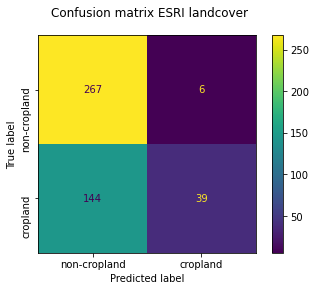

In [109]:
plot_confusion_matrix(**results['ESRI']['confusion'], title='ESRI landcover', save_fig=True)

Visualization

In [110]:
Map = geemap.Map()

Map.setCenter(9.136, 7.433, 6)
esri_vis = {
    'min': 1,
    'max': 10,
    'palette': [
        "#1A5BAB",
        "#358221",
        "#A7D282",
        "#87D19E",
        "#FFDB5C",
        "#EECFA8",
        "#ED022A",
        "#EDE9E4",
        "#F2FAFF",
        "#C8C8C8",
    ],
}

Map.addLayer(esri_image.clip(nigeria_boundaries), esri_vis, "ESRI Land Cover")
Map.add_legend(title="ESRI Land Cover", builtin_legend='ESRI_LandCover')

Map

Map(center=[7.433, 9.136], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

### 2.3 Dynamic World

Access [Dynamic World Land Cover](https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_DYNAMICWORLD_V1?hl=en) landcover product via the GEE catalog.

In [111]:
start_date = '2020-01-01'
end_date = '2021-01-01'
dw_class = geemap.dynamic_world(nigeria_boundaries, start_date, end_date, return_type='class')

In [112]:
dw_class.getInfo()

{'type': 'Image',
 'bands': [{'id': 'label_mode',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 255},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

Transform dataframe with results to Feature Collection (setting crs first)

In [113]:
results_val_gdf = results_val_gdf.set_crs('EPSG:4326')
results_val_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [114]:
val_points = geemap.geopandas_to_ee(results_val_gdf) # convert dataframe with ESA/ESRI results to GEE feature collection (so that we resuse dataframe instead of merging results)
val_points

**Evaluate on validation points**

In [115]:
results_val_points = dw_class.reduceRegions(**{'collection': val_points, 'reducer': ee.Reducer.median(), 'scale': 10}) # need to specify a scale for GEE not to complain
results_val_gdf = geemap.ee_to_geopandas(results_val_points)# rewrites previous gdf
results_val_gdf.rename(columns={'median': 'DW_pixel_value'}, inplace=True)
results_val_gdf

,geometry,ESA_pixel_value,ESRI_pixel_value,date,filename,identifier,label,lat,lon,DW_pixel_value,new_set,set
0,POINT (5.72339 7.50700),10,2,2019-04-03_2020-03-28,199_2019-04-03_2020-03-28.pkl,199,0,7.506996,5.723391,1,testing,training
1,POINT (8.44735 7.59629),20,6,2019-04-03_2020-03-28,1462_2019-04-03_2020-03-28.pkl,1462,0,7.596289,8.447353,5,testing,training
2,POINT (3.72428 9.31324),20,2,2019-04-03_2020-03-28,1677_2019-04-03_2020-03-28.pkl,1677,0,9.313239,3.724280,1,testing,training
3,POINT (7.52667 8.70759),20,6,2019-04-03_2020-03-28,749_2019-04-03_2020-03-28.pkl,749,0,8.707595,7.526669,5,testing,validation
4,POINT (6.17749 12.58490),40,6,2019-04-03_2020-03-28,757_2019-04-03_2020-03-28.pkl,757,0,12.584903,6.177490,5,testing,training
...,...,...,...,...,...,...,...,...,...,...,...,...
451,POINT (12.26825 10.40029),40,6,2019-04-03_2020-03-28,1558_2019-04-03_2020-03-28.pkl,1558,0,10.400290,12.268247,5,testing,validation
452,POINT (8.39291 5.00905),10,2,2019-04-03_2020-03-28,992_2019-04-03_2020-03-28.pkl,992,0,5.009051,8.392915,1,testing,training
453,POINT (11.89715 9.07060),20,6,2019-04-03_2020-03-28,1515_2019-04-03_2020-03-28.pkl,1515,0,9.070604,11.897153,5,testing,training
454,POINT (7.80605 6.49406),10,6,2019-04-03_2020-03-28,600_2019-04-03_2020-03-28.pkl,600,1,6.494056,7.806045,1,testing,training


In [116]:
results_val_gdf['DW_pixel_value'].value_counts()

5    167
1    140
4     79
7     47
0     13
6      7
3      2
2      1
Name: DW_pixel_value, dtype: int64

Confusion matrix

In [117]:
dw_cropland_value = 5 

In [118]:
tp, fn, fp, tn = calculate_confusion(results_val_gdf, 'DW_pixel_value', dw_cropland_value)

In [119]:
len(results_val_gdf) == (tp + fn + fp + tn)

True

In [120]:
results['DW'] = calculate_metrics(tp=tp, fn=fn, fp=fp, tn=tn)
results

{'ESA': {'total_acc': 0.868421052631579,
  'recall': 0.7486338797814208,
  'precision': 0.9072847682119205,
  'f1_score': 0.8203592814371257,
  'selectivity': 0.9487179487179487,
  'confusion': {'tp': 137, 'fn': 46, 'fp': 14, 'tn': 259}},
 'ESRI': {'total_acc': 0.6710526315789473,
  'recall': 0.21311475409836064,
  'precision': 0.8666666666666667,
  'f1_score': 0.3421052631578947,
  'selectivity': 0.978021978021978,
  'confusion': {'tp': 39, 'fn': 144, 'fp': 6, 'tn': 267}},
 'DW': {'total_acc': 0.5921052631578947,
  'recall': 0.44808743169398907,
  'precision': 0.49101796407185627,
  'f1_score': 0.4685714285714286,
  'selectivity': 0.6886446886446886,
  'confusion': {'tp': 82, 'fn': 101, 'fp': 85, 'tn': 188}}}

82 101 85 188


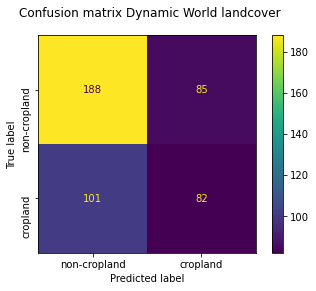

In [121]:
plot_confusion_matrix(**results['DW']['confusion'], title='Dynamic World landcover', save_fig=True)

Save results

In [122]:
rel_results_path = Path('../results')
rel_results_path.mkdir(parents=True, exist_ok=True)

with (rel_results_path / f'landcovermaps_nigeria_{eval_set}.json').open('w') as f:
    json.dump(results, f)

Visualization

In [123]:
Map = geemap.Map()
Map.setCenter(9.136, 7.433, 6)

dw_vis = {
    "min": 0,
    "max": 8,
    "palette": [
        "#419BDF",
        "#397D49",
        "#88B053",
        "#7A87C6",
        "#E49635",
        "#DFC35A",
        "#C4281B",
        "#A59B8F",
        "#B39FE1",
    ],
}

Map.addLayer(dw_class.clip(nigeria_boundaries), dw_vis, 'DW Land Cover', True)

Map.add_legend(title="Dynamic World Land Cover", builtin_legend='Dynamic_World')
Map

Map(center=[7.433, 9.136], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

### TODOs
- Validate with sklearn confusion matrix and plot for each landcover map